In [1]:
using Pkg
Pkg.activate("..")

 Activating environment at `~/Documents/Catlab/AlgebraicDynamics.jl/Project.toml`


In [2]:
using AlgebraicDynamics

using Catlab
using Catlab.CategoricalAlgebra
using Catlab.CategoricalAlgebra.CSets
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Catlab.Graphs

using Catlab.Graphs.BasicGraphs: TheoryGraph, Graph
using Catlab.Theories: id
import Catlab.CategoricalAlgebra: subpart

using DifferentialEquations

using Plots



┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1260


In [3]:
# Data migration code

function migrate!(Y::ACSet{CD, AD}, X::ACSet, FOb::Dict, FHom::Dict) where {CD, AD}
  CD.ob ⊆ keys(FOb)     || error("Every object in $CD must be a key in $FOb")
  CD.hom ⊆ keys(FHom)   || error("Every hom in $CD must be a key in $FHom")
  AD.attr ⊆ keys(FHom)  || error("Every attribute in $AD must be a key in $FHom")
  
  for (obY, obX) in FOb  
    add_parts!(Y, obY, nparts(X, obX))
  end

  for (homY, homX) in FHom
    set_subpart!(Y, homY, subpart(X, homX))
  end
  return Y
end

function (::Type{T})(X::ACSet, FOb::Dict, FHom::Dict) where T <: AbstractACSet
  Y = T(); migrate!(Y, X, FOb, FHom)
end


subpart(acs::ACSet, expr::GATExpr{:id}) = parts(acs, first(dom(expr)))

subpart (generic function with 5 methods)

# Implementing Resources Sharing Machines

In this notebook, we describe the process of composing dynamical systems as (1) resource sharers, (2) machines, and (3) resource sharing machines.

These features are implemented more complicated-ly in the AlgebraicDynamics.jl package. In this notebook we implement "baby" versions for the sake of clarity.

## A Theory of Machines

We define a machine to be a system which takes input, updates its internal state, and exposes some output. The schema for machines is:

<img src="images/Theory of Machines.png" alt="schema for theory of machines" style="width: 600px;"/>

Note that this composition pattern is a special case of an operation in the operad of wiring diagrams of finite sets where the codomain is the unit.

In [4]:
@present TheoryMachines(FreeSchema) begin        
    Dynamics::Data

    Box::Ob
    InPort::Ob
    OutPort::Ob
    StateVariable::Ob

    parameterizes::Hom(InPort, Box)
    state::Hom(OutPort, StateVariable)
    system::Hom(StateVariable, Box)
    feeder::Hom(InPort, OutPort)
    
    dynamics::Attr(Box, Dynamics)
end

const AbstractMachine = AbstractACSetType(TheoryMachines)
const Machine = ACSetType(TheoryMachines, index=[:parameterizes, :state, :system, :feeder, :dynamics])
Machine() = Machine{Function}()

Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:Box, :InPort, :OutPort, :StateVariable),(:parameterizes, :state, :system, :feeder),(2, 3, 4, 2),(1, 4, 1, 3)},Catlab.Theories.AttrDesc{Catlab.Theories.CatDesc{(:Box, :InPort, :OutPort, :StateVariable),(:parameterizes, :state, :system, :feeder),(2, 3, 4, 2),(1, 4, 1, 3)},(:Dynamics,),(:dynamics,),(1,),(1,)},Tuple{Dynamics},(:dynamics, :feeder, :parameterizes, :state, :system),(),Tables,Indices} where Indices<:NamedTuple where Tables<:NamedTuple where Dynamics

In [19]:
# Turn a Machine into an ODE problem

function get_dynamics(m::AbstractMachine)
    function dynamics!(newstate, u)
        for b in parts(m, :Box)
            ivalues = view(u,  subpart(m, subpart(m, incident(m, b, :parameterizes),  :feeder), :state))
            states = incident(m, b, :system)
            dynamics = subpart(m, b, :dynamics)
            view(newstate, states) .= dynamics(view(u, states), ivalues)
        end
        newstate
    end
end

function vectorfield(m::AbstractMachine)
    total_dynamics! = get_dynamics(m)
    function f(u, p, t)
        return total_dynamics!(zero(u),u)
    end
end

vectorfield (generic function with 1 method)

## Lokta-Volterra as machines

A parameterized ODE modeling a rabbit population takes as input a population of predators $\mathsf{pred}$ and evolves according to $$\dot r(\mathsf{pred})\alpha r - \beta r(\mathsf{pred})$$.

Similarly a ODE modeling a fox population takes as input a population of prey $\mathsf{prey}$ and evolves according to $$\dot f(\mathsf{prey}) = -\gamma f + \delta  f(\mathsf{prey}).$$

In [20]:
# parameters and initial condition chosen to match the example in 
#      https://algebraicjulia.github.io/AlgebraicPetri.jl/dev/examples/predation/lotka-volterra/
α = .3
β = .015
γ = .7
δ = β

u0 = [10.0, 100.0]

dotr = (r,pred) -> [α*r[1] - β*r[1]*pred[1]]
dotf = (f,prey) -> [δ*f[1]*prey[1] - γ*f[1]]

lv = Machine()
add_parts!(lv, :Box,    2, dynamics = [dotr, dotf])
add_parts!(lv, :StateVariable,  2, system = [1,2])
add_parts!(lv, :OutPort,2, state = [1,2])
add_parts!(lv, :InPort, 2, parameterizes = [1,2], feeder = [2,1])

lv

ACSet with elements Box = 1:2, InPort = 1:2, OutPort = 1:2, StateVariable = 1:2
┌─────┬──────────┐
│ Box │ dynamics │
├─────┼──────────┤
│   1 │      #17 │
│   2 │      #19 │
└─────┴──────────┘
┌────────┬───────────────┬────────┐
│ InPort │ parameterizes │ feeder │
├────────┼───────────────┼────────┤
│      1 │             1 │      2 │
│      2 │             2 │      1 │
└────────┴───────────────┴────────┘
┌─────────┬───────┐
│ OutPort │ state │
├─────────┼───────┤
│       1 │     1 │
│       2 │     2 │
└─────────┴───────┘
┌───────────────┬────────┐
│ StateVariable │ system │
├───────────────┼────────┤
│             1 │      1 │
│             2 │      2 │
└───────────────┴────────┘

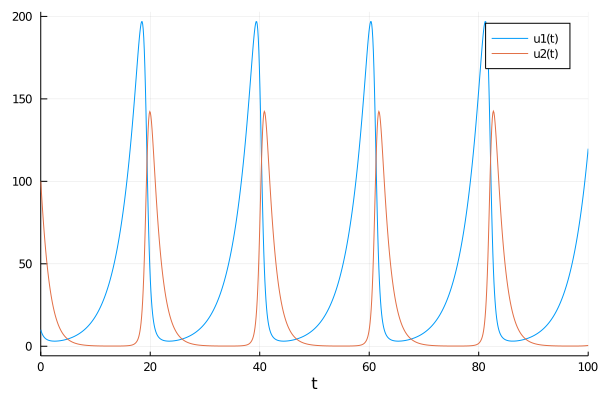

In [21]:
prob = ODEProblem(vectorfield(lv), u0, (0.0, 100.0))
sol = solve(prob)
plot(sol)

## Modularity of Machines

One of the great things about compositional dynamics is that you can build your models modularly.

For example consider an ecosystem composed of little fish, big fish, and sharks where the big fish are predators to the little fish and prey to the sharks. To construct the ODE corresponding to this model, you might get lost trying to keep all of your variables straight. However, as a composition of machines, it is much more straightforward.

In [22]:
α = .3
β = .015
γ = .7
δ = β
β′ = .017
γ′ = .35
δ′ = β′

u0 = [100.0, 10.0, 2.0]

dotfish(f, x) = [α*f[1] - β*x[1]*f[1]]
dotFISH(F, x) = [δ*x[1]*F[1] - γ*F[1] - β′*x[2]*F[1]]    # x[1] - prey, x[2] - predator
dotsharks(s, x) = [-γ′*s[1] + δ′*s[1]*x[1]]

lv3 = Machine()
add_parts!(lv3, :Box,    3, dynamics = [dotfish, dotFISH, dotsharks])
add_parts!(lv3, :StateVariable,  3, system = [1,2,3])
add_parts!(lv3, :OutPort,3, state = [1,2,3])
add_parts!(lv3, :InPort, 4, parameterizes = [1,2,2,3], feeder = [2,1,3,2])

lv3

ACSet with elements Box = 1:3, InPort = 1:4, OutPort = 1:3, StateVariable = 1:3
┌─────┬───────────┐
│ Box │  dynamics │
├─────┼───────────┤
│   1 │   dotfish │
│   2 │   dotFISH │
│   3 │ dotsharks │
└─────┴───────────┘
┌────────┬───────────────┬────────┐
│ InPort │ parameterizes │ feeder │
├────────┼───────────────┼────────┤
│      1 │             1 │      2 │
│      2 │             2 │      1 │
│      3 │             2 │      3 │
│      4 │             3 │      2 │
└────────┴───────────────┴────────┘
┌─────────┬───────┐
│ OutPort │ state │
├─────────┼───────┤
│       1 │     1 │
│       2 │     2 │
│       3 │     3 │
└─────────┴───────┘
┌───────────────┬────────┐
│ StateVariable │ system │
├───────────────┼────────┤
│             1 │      1 │
│             2 │      2 │
│             3 │      3 │
└───────────────┴────────┘

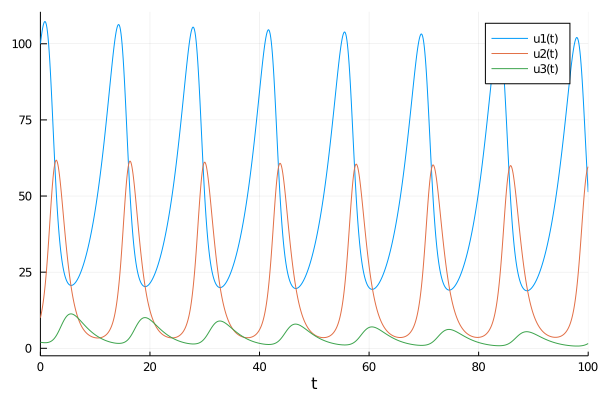

In [23]:
prob = ODEProblem(vectorfield(lv3), u0, (0.0, 100.0))
sol = solve(prob)
plot(sol)

## Machines from Graphs

We can further improve upon the modularity of machines by building machines out of graphs where each vertex is equipped with a vector field. We want to assume that the dynamics to vertex $v$ has $n$ parameters where $n$ is the number of edges incoming to $v$. The ordering of the parameters is induced by the ordering of the edges.

In [24]:
@present TheoryLabeledGraph <: TheoryGraph begin
    Label::Data
    label::Attr(V, Label)
end

const AbstractLabeledGraph = AbstractACSetType(TheoryLabeledGraph)
const LabeledGraph = ACSetType(TheoryLabeledGraph, index=[:src, :tgt, :label])
DynamGraph() = LabeledGraph{Function}()

DynamGraph (generic function with 1 method)

In [25]:
V = TheoryLabeledGraph[:V]
E = TheoryLabeledGraph[:E]

Machine(g::LabeledGraph) = Machine(g, 
   Dict(:InPort => :E, :OutPort => :E, :Box => :V, :StateVariable => :V),
   Dict(:parameterizes => :src, :feeder => id(E), :state => :tgt, :system => id(V), :dynamics => :label)
)

Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:Box, :InPort, :OutPort, :StateVariable),(:parameterizes, :state, :system, :feeder),(2, 3, 4, 2),(1, 4, 1, 3)},Catlab.Theories.AttrDesc{Catlab.Theories.CatDesc{(:Box, :InPort, :OutPort, :StateVariable),(:parameterizes, :state, :system, :feeder),(2, 3, 4, 2),(1, 4, 1, 3)},(:Dynamics,),(:dynamics,),(1,),(1,)},Tuple{Dynamics},(:dynamics, :feeder, :parameterizes, :state, :system),(),Tables,Indices} where Indices<:NamedTuple where Tables<:NamedTuple where Dynamics

In [26]:
lv3_graph = DynamGraph()
add_parts!(lv3_graph, :V, 3, label=[dotfish, dotFISH, dotsharks])
add_parts!(lv3_graph, :E, 4, src=[1,2,2,3], tgt=[2,1,3,2])

lv3_graph

ACSet with elements V = 1:3, E = 1:4
┌───┬───────────┐
│ V │     label │
├───┼───────────┤
│ 1 │   dotfish │
│ 2 │   dotFISH │
│ 3 │ dotsharks │
└───┴───────────┘
┌───┬─────┬─────┐
│ E │ src │ tgt │
├───┼─────┼─────┤
│ 1 │   1 │   2 │
│ 2 │   2 │   1 │
│ 3 │   2 │   3 │
│ 4 │   3 │   2 │
└───┴─────┴─────┘

In [27]:
lv3′ = Machine(lv3_graph)

ACSet with elements Box = 1:3, InPort = 1:4, OutPort = 1:4, StateVariable = 1:3
┌─────┬───────────┐
│ Box │  dynamics │
├─────┼───────────┤
│   1 │   dotfish │
│   2 │   dotFISH │
│   3 │ dotsharks │
└─────┴───────────┘
┌────────┬───────────────┬────────┐
│ InPort │ parameterizes │ feeder │
├────────┼───────────────┼────────┤
│      1 │             1 │      1 │
│      2 │             2 │      2 │
│      3 │             2 │      3 │
│      4 │             3 │      4 │
└────────┴───────────────┴────────┘
┌─────────┬───────┐
│ OutPort │ state │
├─────────┼───────┤
│       1 │     2 │
│       2 │     1 │
│       3 │     3 │
│       4 │     2 │
└─────────┴───────┘
┌───────────────┬────────┐
│ StateVariable │ system │
├───────────────┼────────┤
│             1 │      1 │
│             2 │      2 │
│             3 │      3 │
└───────────────┴────────┘

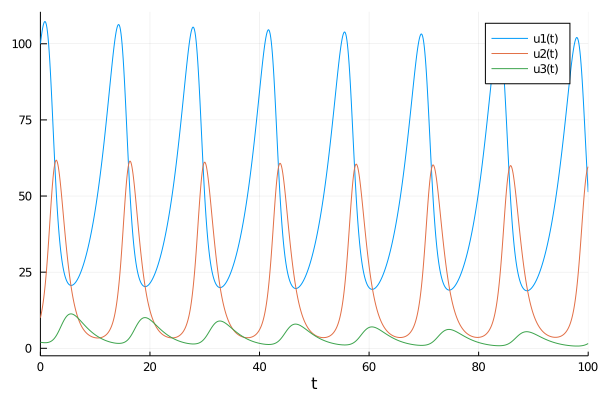

In [28]:
prob = ODEProblem(vectorfield(lv3′), u0, (0.0, 100.0))
sol = solve(prob)
plot(sol)

This migration from dynamics equipped graphs to machines makes things like cellular automata easy to code up!

In [152]:
function repeated_dynamics(dynam, expected_nbs, boundary_case)
    function dynamics(x,nbs)
        if length(nbs)==expected_nbs
            return dynam(x[1],nbs...)
        end
        return boundary_case
    end
end


function rule(n)
    function rule(c,l,r)
        R = digits(n, base=2, pad = 8)
        d = [l,c,r]
        i = sum([d[k]*2^(k-1) for k=1:length(d)])
        return R[i+1]
    end
end

rule (generic function with 1 method)

In [156]:
n = 20
rule_number = 94
R = rule(rule_number)


d = repeated_dynamics(R, 2, 0)

(::var"#dynamics#85"{var"#rule#87"{Int64},Int64,Int64}) (generic function with 1 method)

In [157]:
g = DynamGraph()

add_parts!(g, :V, n, label = fill(d, n))

edgesr = add_parts!(g, :E, n-1, src = 1:(n-1), tgt = 2:n)
edgesl = add_parts!(g, :E, n-1, src = 2:n, tgt = 1:(n-1))

20:38

In [158]:
N = 20
update! = get_dynamics(Machine(g))

u0 = zeros(n)
u0[ceil(Int,n/2)] = 1

xs = Array{Int64}(undef, N+1, n)
xs[1, :] = u0

for i in 1:N
    update!(view(xs, i + 1, 1:n), view(xs, i, 1:n))
end

xs


21×20 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  1  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  1  0  1  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  1  1  0  1  1  1  0  0  0  0  0  0  0
 0  0  0  0  0  1  1  0  1  0  1  0  1  1  0  0  0  0  0  0
 0  0  0  0  1  1  1  0  1  0  1  0  1  1  1  0  0  0  0  0
 0  0  0  1  1  0  1  0  1  0  1  0  1  0  1  1  0  0  0  0
 0  0  1  1  1  0  1  0  1  0  1  0  1  0  1  1  1  0  0  0
 0  1  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  1  0  0
 0  1  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  1  1  0
 0  1  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  0
 0  1  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  0
 0  1  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  0
 0  1  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  0
 0  1  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  0
 0  1  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  0
 0  1  1  0  1  0 

## Resource Sharers

In contrast to machines --- which model directed interaction between models --- resource sharers model undirect interaction between models. It allows the user to define several models and then glue them together by identifying variables across models.

For example consider three models 
1. rabbit growth - $\dot r = \alpha r$
2. rabbit/fox predation - $\dot r = -\beta r f, \dot f = \delta rf$
3. fox decline - $\dot f = -\gamma f$

Of course there aren't two separate rabbit populations --- one that grows and one that is preyed upon by foxes. They are the same rabbit population. In identifying these rabbit populations we *add* the effects on the vector fields. Similarly with the fox population. Thus the total system is the standard LV model.

Let's see how we would view a resource sharer as a C-Set.

First the theory looks like this. Like in machines we have a box equipped with a dynamics and states assigned to boxes. Additionally we have ports which expose states and junctions which identity ports. 

In [240]:
@present TheoryRS(FreeSchema) begin        
    Dynamics::Data

    Box::Ob
    StateVariable::Ob
    Port::Ob
    Junction::Ob

    state::Hom(Port, StateVariable)
    system::Hom(StateVariable, Box)
    junction::Hom(Port, Junction)
    
    dynamics::Attr(Box, Dynamics)
end

const AbstractRS = AbstractACSetType(TheoryRS)
const RS = ACSetType(TheoryRS, index=[:state, :system, :junction, :dynamics])
RS() = RS{Function}()

Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:Box, :StateVariable, :Port, :Junction),(:state, :system, :junction),(3, 2, 3),(2, 1, 4)},Catlab.Theories.AttrDesc{Catlab.Theories.CatDesc{(:Box, :StateVariable, :Port, :Junction),(:state, :system, :junction),(3, 2, 3),(2, 1, 4)},(:Dynamics,),(:dynamics,),(1,),(1,)},Tuple{Dynamics},(:dynamics, :junction, :state, :system),(),Tables,Indices} where Indices<:NamedTuple where Tables<:NamedTuple where Dynamics

In [241]:
function get_dynamics(rs::AbstractRS)
    function dynamics!(newstate, u)
        for b in parts(rs, :Box)
            dynamics = subpart(rs, b, :dynamics)
            states = incident(rs, b, :system)
            view(newstate, states) .= dynamics(view(u, states))
        end
        
        for j in parts(rs, :Junction)
            states = subpart(rs, incident(rs, j, :junction), :state)
            view(newstate, states) .= sum(view(newstate, states))
        end
        newstate
    end
end

function vectorfield(rs::AbstractRS)
    total_dynamics! = get_dynamics(rs)
    function f(u, p, t)
        return total_dynamics!(zero(u),u)
    end
end

vectorfield (generic function with 2 methods)

In [242]:
α = .3
β = .015
γ = .7
δ = β

lv = RS()

rgrowth(x) = α*x
fdecline(x) = -γ*x
rfpredation(x) = [-β*x[1]*x[2], δ*x[1]*x[2]]

add_parts!(lv, :Box, 3, dynamics=[rgrowth, rfpredation, fdecline])
add_parts!(lv, :StateVariable, 4, system=[1,2,2,3])
add_parts!(lv, :Junction, 2)
add_parts!(lv, :Port, 4, state=1:4, junction=[1,1,2,2])

lv

ACSet with elements Box = 1:3, StateVariable = 1:4, Port = 1:4, Junction = 1:2
┌─────┬─────────────┐
│ Box │    dynamics │
├─────┼─────────────┤
│   1 │     rgrowth │
│   2 │ rfpredation │
│   3 │    fdecline │
└─────┴─────────────┘
┌───────────────┬────────┐
│ StateVariable │ system │
├───────────────┼────────┤
│             1 │      1 │
│             2 │      2 │
│             3 │      2 │
│             4 │      3 │
└───────────────┴────────┘
┌──────┬───────┬──────────┐
│ Port │ state │ junction │
├──────┼───────┼──────────┤
│    1 │     1 │        1 │
│    2 │     2 │        1 │
│    3 │     3 │        2 │
│    4 │     4 │        2 │
└──────┴───────┴──────────┘

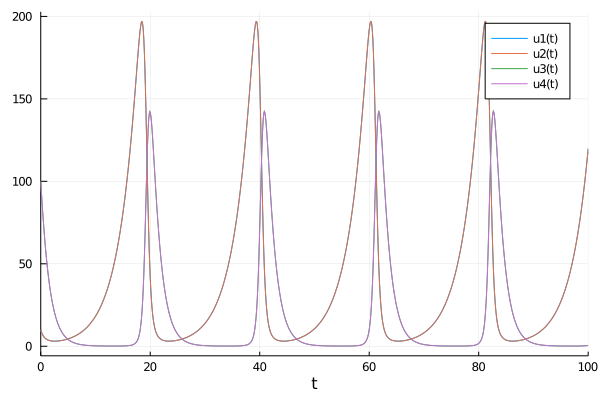

In [243]:
u0 = [10.0, 10.0, 100.0, 100.0]
prob = ODEProblem(vectorfield(lv), u0, (0.0, 100.0))
sol = solve(prob)
plot(sol)

## Pushouts of Resource Sharers

We can get more complicated by combining predation situations. For example suppose there is a hawk population that also preys on rabbits. Now we can see this as five individual systems which share variables:
1. rabbit growth - $\dot r = \alpha r$
2. rabbit/fox predation - $\dot r = -\beta r f, \dot f = \delta rf$
3. fox decline - $\dot f = -\gamma f$
4. rabbit/hawk predation - $\dot r = -\beta' rh, \dot h = \delta' rh$
5. hawk decline - $\dot h = -\gamma' h$

In [275]:
β′ = .01
δ′ = β′
γ′ = .5

rhpredation(x) = [-β′*x[1]*x[2], δ′*x[1]*x[2]]
hdecline(x) = -γ′*x

hdecline (generic function with 1 method)

We could construct the above explicity as a resource sharer but it would be much nicer to construct it as the pushout of two Lokta-Volterra models --- the fox/rabbit model and the hawk/rabbit model --- where the apex is the model of rabbit growth.

In [276]:
function loktavolterra_rs(α, β, γ, δ)
    lv = RS()
    
    growth(x) = α*x
    decline(x) = -γ*x
    predation(x) = [-β*x[1]*x[2], δ*x[1]*x[2]]
    
    add_parts!(lv, :Box, 3, dynamics=[growth, predation, decline])
    add_parts!(lv, :StateVariable, 4, system=[1,2,2,3])
    add_parts!(lv, :Junction, 2)
    add_parts!(lv, :Port, 4, state=1:4, junction=[1,1,2,2])
    return lv
end


rf_rs = loktavolterra_rs(α, β, γ, δ)
rh_rs = loktavolterra_rs(α, β′, γ′, δ′)

r_rs = RS()
add_parts!(r_rs, :Box, 1, dynamics=[rgrowth])
add_parts!(r_rs, :StateVariable, 1, system=[1])
add_parts!(r_rs, :Junction, 1)
add_parts!(r_rs, :Port, 1, state = [1], junction = [1])

r_rs

ACSet with elements Box = 1:1, StateVariable = 1:1, Port = 1:1, Junction = 1:1
┌─────┬──────────┐
│ Box │ dynamics │
├─────┼──────────┤
│   1 │  rgrowth │
└─────┴──────────┘
┌───────────────┬────────┐
│ StateVariable │ system │
├───────────────┼────────┤
│             1 │      1 │
└───────────────┴────────┘
┌──────┬───────┬──────────┐
│ Port │ state │ junction │
├──────┼───────┼──────────┤
│    1 │     1 │        1 │
└──────┴───────┴──────────┘

In [277]:
# Pushout
rf_transform = ACSetTransformation((Box=[1], StateVariable=[1], Junction=[1], Port=[1]), r_rs, rf_rs)
rh_transform = ACSetTransformation((Box=[1], StateVariable=[1], Junction=[1], Port=[1]), r_rs, rh_rs)
rfh_rs = ob(pushout(rf_transform, rh_transform))

rfh_rs

Box,dynamics
1,growth
2,predation
3,decline
4,predation
5,decline
StateVariable,system
1,1
2,2
3,2
4,3


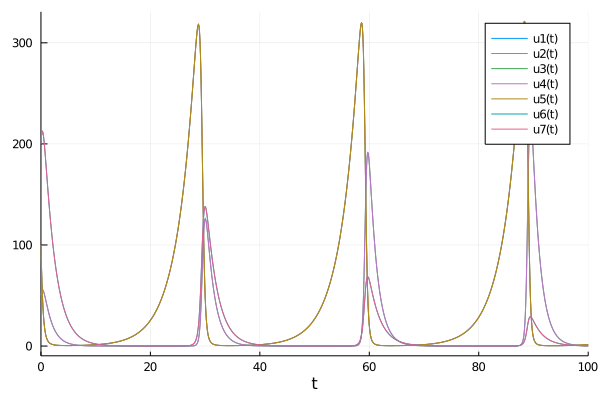

In [278]:
r0 = 100.0
f0 = 50.0
h0 = 200.0

u0 = [r0, r0, f0, f0, r0, h0, h0]
prob = ODEProblem(vectorfield(rfh_rs), u0, (0.0, 100.0))
sol = solve(prob)
plot(sol)

## Appendix

In [205]:
# Discrete update function

function update!(y::AbstractVector, f::Function, x::AbstractVector, args...)
    y .= f(x, args...)
end

function update!(newstate::AbstractVector, dm::AbstractMachine, state::AbstractVector) 
    
    for b in parts(dm, :Box)
        ivalues = view(state,  subpart(dm, incident(dm, b, :parameterizes), :feeder))
        states = incident(dm, b, :system)
        dynamics = subpart(dm, b, :dynamics)
        newvalues = update!(view(newstate, states),
                            dynamics, 
                            view(state, states), 
                            ivalues)
    end
    
    return newstate
end

ErrorException: cannot define function update!; it already has a value

In [ ]:
α = 1.2
β = 0.1
γ = 1.3
δ = 0.1

dotr = (r,i) -> [α*r[1] - β*i[1]*r[1]]
dotf = (f,j) -> [-γ*f[1] + δ* j[1]* f[1]]

function eulers(f::Function, h::Float64) 
    return (x0, args...) -> x0 .+ h*f(x0, args...)
end

function approx(f::Function, h::Float64)
    return (x0, args...) -> solve(ODEProblem((x,p,t) -> f(x0, args...), x0, (0, h)), 
                                    save_everystep = false, save_start=false,save_end = true)[1]
end

h = 0.1

lv = Machine()
add_parts!(lv, :Box,    2, dynamics = [eulers(dotr,h), eulers(dotf,h)])
add_parts!(lv, :StateVariable,  2, system = [1,2], value=[17, 11])
add_parts!(lv, :OutPort,2, state = [1,2])
add_parts!(lv, :InPort, 2, parameterizes = [1,2], feeder = [2,1])

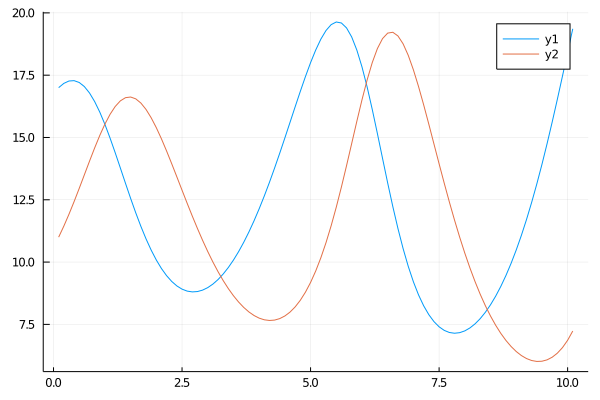

In [198]:
N = 100
k = nparts(lv, :StateVariable)

xs = Array{Float64}(undef, N + 1, k)
xs[1, : ] = subpart(lv, :value)

for i in 1:N
    update!(view(xs,i+1, 1:k), lv, view(xs, i, 1:k))
end

ts = map(t -> t*h, 1:N+1)
rs = xs[:, 1]
fs = xs[:, 2]

plot(ts, rs)
plot!(ts, fs)